# Neumonia Tokyo Example

Example adopted from

* 栗原考次, & 石岡文生. (2021). エシェロン解析: 階層化して視る時空間データ. 共立出版.

### References:

* Reading Polygons with NetworkX https://networkx.org/documentation/stable//auto_examples/geospatial/plot_polygons.html

### Notes:

* This example does not use ``read_shp()`` of NetworkX since it has been deprecated after version 3.0: https://networkx.org/documentation/stable//auto_examples/geospatial/extended_description.html

In [18]:
import warnings
warnings.filterwarnings('ignore')

## Version Information

In [19]:
import echelon

## For shapefile -> adjacency conversion
import networkx  # For graph handling.
import geopandas  # For reading shapefiles.
import libpysal  # For constructing "Queen" neighborhoods.

import matplotlib
# For some reason, NetworkX plot functionality (nx.draw()) seems to fail with a newer matplotlib:
# https://stackoverflow.com/questions/63198347/attributeerror-module-matplotlib-cbook-has-no-attribute-iterable
# assert matplotlib.__version__ =='2.2.3'

for module in [echelon, networkx, matplotlib, geopandas, libpysal]:
    print(module.__name__, module.__version__)

echelon 1.0.3
networkx 2.6.3
matplotlib 3.4.3
geopandas 0.10.2
libpysal 4.5.1


## Downloading Data

In [20]:
import urllib.request
from pathlib import Path
import zipfile
import shutil

data_dir = Path('data/application-neumonia-Tokyo')
data_dir.mkdir(exist_ok=True, parents=True)

_filename = data_dir / 'onepoint.zip'
if not _filename.exists():
    urllib.request.urlretrieve('https://fishi.ems.okayama-u.ac.jp/fishioka/onepoint.zip', _filename)

if not (data_dir / 'onepoint').exists():
    with zipfile.ZipFile(_filename) as _f:
        _f.extractall(data_dir)

    for _p in (data_dir / 'onepoint').glob("*"):
        shutil.move(str(_p), str(data_dir))

print([a.name for a in (data_dir / 'data').iterdir()])
print([a.name for a in (data_dir / 'shapefile').iterdir()])

['table42.csv', 'table43.csv']
['jpn_adm.prj', 'jpn_adm.sbn', 'jpn_adm.shp', 'jpn_adm.shx', 'jpn_adm.sbx', 'jpn_adm.shp.xml', 'jpn_adm.dbf']


## Loading data

In [21]:
import numpy as np
import geopandas as gpd
import networkx as nx
from libpysal import weights
from pathlib import Path

gdf = gpd.read_file(data_dir / 'shapefile' / 'jpn_adm.shp')
Tokyo_gdf = gdf[gdf['adm_code'].isin([str(s) for s in range(13101, 13123+1)])]
Tokyo_gdf = Tokyo_gdf.reset_index(drop=True)

import pandas as pd

table42 = pd.read_csv(data_dir / 'data/table42.csv')
table43 = pd.read_csv(data_dir / 'data/table43.csv', encoding="shift-jis")

from IPython.display import display

display(table42)
display(table43.head(3))
display(Tokyo_gdf.head(3))

,age,n,o
0,1,539781,2
1,2,3174956,89
2,3,867227,2837


,ID,Name,n,n1,n2,n3,o
0,1,千代田区,29987,3836,21637,4514,11
1,2,中央区,71448,9705,51976,9767,29
2,3,港区,117353,16505,83354,17494,31


,adm_code,KEN,SIKUCHOSON,geometry
0,13101,東京都,千代田区,"POLYGON ((139.77010 35.70527, 139.77310 35.705..."
1,13102,東京都,中央区,"POLYGON ((139.78889 35.69466, 139.79041 35.689..."
2,13103,東京都,港区,"MULTIPOLYGON (((139.75751 35.62413, 139.75349 ..."


## Construct adjacency information

In [22]:
# "Queen" adjacency graph. Two polygons are connected
# if they share a single point on their boundary (analogue to the "Moore" neighborhood).
queen = weights.Queen.from_dataframe(Tokyo_gdf)

### Bonus: base plot

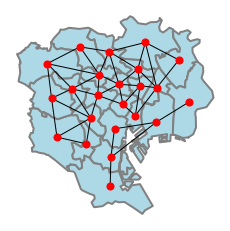

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def _graph_plot(_gdf, adj_weight):
    graph = queen.to_networkx()
    # Extract the centroids for connecting the regions, which is
    # the average of the coordinates that define the polygon's boundary
    centroids = np.column_stack((_gdf.centroid.x, _gdf.centroid.y))

    # To plot with networkx, we need to merge the nodes back to
    # their positions in order to plot in networkx
    positions = dict(zip(graph.nodes, centroids))

    # plot with a nice basemap
    ax = _gdf.plot(linewidth=2, edgecolor="grey", facecolor="lightblue")
    nx.draw(graph, positions, ax=ax, node_size=50, node_color="red")
    plt.show()

_graph_plot(Tokyo_gdf, queen)

## Preparing Data

In [24]:
## Derived columns
p = table42['o'] / table42['n']
e = table43['n1']*p[0] + table43['n2']*p[1] + table43['n3']*p[2]
SMR = table43['o'] / e
table43['SMR'] = SMR

## Attach adjacency information
adj = queen.to_adjlist()
table43['adjacency'] = (
    adj.groupby('focal')['neighbor']
    .agg(list).map(lambda l: [table43.iloc[i]['Name'] for i in l])
)
table43

,ID,Name,n,n1,n2,n3,o,SMR,adjacency
0,1,千代田区,29987,3836,21637,4514,11,0.714861,"[中央区, 新宿区, 文京区, 台東区]"
1,2,中央区,71448,9705,51976,9767,29,0.867116,"[千代田区, 台東区, 墨田区]"
2,3,港区,117353,16505,83354,17494,31,0.519902,"[品川区, 江東区]"
3,4,新宿区,170255,14992,126589,28674,74,0.759702,"[千代田区, 文京区, 渋谷区, 中野区, 豊島区]"
4,5,文京区,101755,12938,71297,17520,41,0.690695,"[千代田区, 北区, 荒川区, 新宿区, 台東区, 豊島区]"
5,6,台東区,99346,9150,69041,21155,76,1.067797,"[千代田区, 中央区, 荒川区, 文京区, 墨田区]"
6,7,墨田区,131814,14372,90833,26609,75,0.836617,"[中央区, 荒川区, 足立区, 台東区, 葛飾区]"
7,8,江東区,250950,33457,169528,47965,131,0.809710,"[品川区, 港区, 江戸川区]"
8,9,品川区,187822,22083,131278,34461,110,0.944241,"[港区, 大田区, 江東区]"
9,10,目黒区,129443,14973,91961,22509,71,0.930927,"[世田谷区, 渋谷区]"


### Bonus: Data Visualization

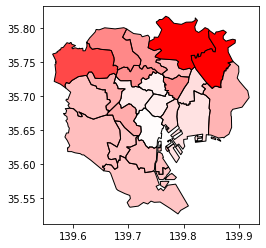

In [25]:
%matplotlib inline
from matplotlib.colors import to_rgba

_merged_gdf = pd.merge(Tokyo_gdf, table43, left_on='SIKUCHOSON', right_on='Name')
_merged_gdf.plot(color=_merged_gdf['SMR'].map(lambda v: to_rgba('red', alpha=min(1, v * .8) ** 5)), edgecolor='black')
None

## Constructing Echelon

In [26]:
from echelon.api import DataFrameEchelonAnalysis

analyzer = DataFrameEchelonAnalysis()
result = analyzer(table43, 'SMR', 'Name', 'adjacency')
print(analyzer.dendrogram(result))

E10(江東区): [港区, 江東区]
 (max: 0.8097101496026745)

├── E9(荒川区): [文京区, 千代田区, 新宿区, 墨田区, 中央区, 目黒区, 杉並区, 世田谷区, 荒川区]
│    (max: 0.9542372963272185)
│   
│   ├── E8(中野区): [中野区]
│   │    (max: 0.9922921961759763)
│   │   
│   │   ├── E7(北区): [北区]
│   │   │    (max: 1.0375137862297261)
│   │   │   
│   │   │   ├── E2(練馬区): [豊島区, 板橋区, 練馬区]
│   │   │   │    (max: 1.1694088184210711)
│   │   │   │   
│   │   │   └── E1(葛飾区): [足立区, 葛飾区]
│   │   │        (max: 1.2984145393208892)
│   │   │       
│   │   └── E4(渋谷区): [渋谷区]
│   │        (max: 0.9988848483530447)
│   │       
│   └── E3(台東区): [台東区]
│        (max: 1.0677968541200462)
│       
├── E6(品川区): [大田区, 品川区]
│    (max: 0.9442411594508717)
│   
└── E5(江戸川区): [江戸川区]
     (max: 0.9797238558394804)
    


## Hotspot Detection

In [27]:
hotspots = analyzer.hotspots(result, data=(table43, 'Name', 'n', 'o'), score='binomial')
hotspots

,spot,score,c(Z),log_lambda
6,"[練馬区, 板橋区, 豊島区, 葛飾区, 足立区, 北区]",46.209348,1217,46.209348
10,"[中野区, 北区, 練馬区, 板橋区, 豊島区, 葛飾区, 足立区, 渋谷区, 台東区, 荒川区]",41.870986,1519,41.870986
1,"[葛飾区, 足立区]",39.235993,532,39.235993
8,"[北区, 練馬区, 板橋区, 豊島区, 葛飾区, 足立区, 渋谷区, 中野区]",37.607581,1372,37.607581
0,[葛飾区],14.606849,214,14.606849
3,"[練馬区, 板橋区]",5.669690,466,5.669690
4,"[練馬区, 板橋区, 豊島区]",4.310773,554,4.310773
2,[練馬区],3.466766,265,3.466766
5,[台東区],1.187074,76,1.187074
7,[渋谷区],0.000000,59,0.000000


## Plotting Detected Hotspots (1)

In [28]:
AlphabetNames = {
    '千代田区': 'Chiyoda', '中央区': 'Chuo', '港区': 'Minato', '新宿区': 'Shinjuku',
     '文京区': 'Bunkyo', '台東区': 'Taito', '墨田区': 'Sumida', '江東区': 'Koto',
     '品川区': 'Shinagawa', '目黒区': 'Meguro', '大田区': 'Ota', '世田谷区': 'Setagaya',
     '渋谷区': 'Shibuya', '中野区': 'Nakano', '杉並区': 'Suginami', '豊島区': 'Toshima',
     '北区': 'Kita', '荒川区': 'Arakawa', '板橋区': 'Itabashi', '練馬区': 'Nerima',
     '足立区': 'Adachi', '葛飾区': 'Katsushika', '江戸川区': 'Edogawa'
}

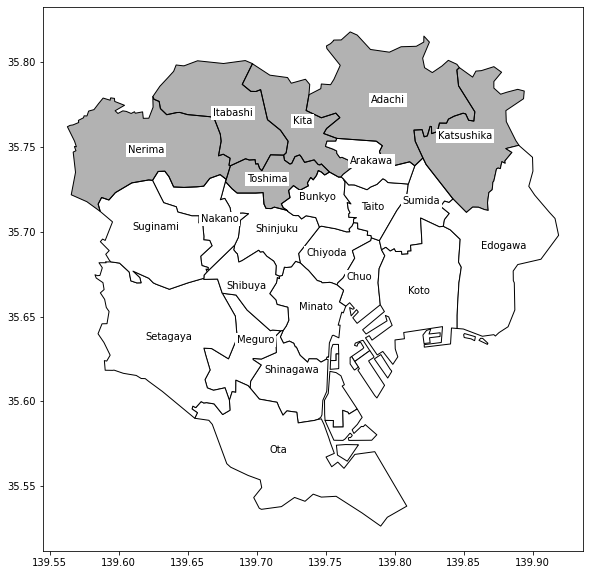

In [29]:
def plot_labeled_map(c: gpd.GeoDataFrame, name_col: str, label_col: str):
    c['coords'] = c['geometry'].apply(lambda x: x.representative_point().coords[:])
    c['coords'] = [coords[0] for coords in c['coords']]

    ## Coloring
    ax = c.plot(color=c[label_col].map(lambda s:
                                  {True: to_rgba('black', alpha=0.3),
                                  False: to_rgba('white')}[s]
                                 ),
           edgecolor='black',
          figsize=(10, 10))

    ## Assign names
    for _, row in c.iterrows():
        ax.text(row.coords[0], row.coords[1],
                s=row[name_col],
                horizontalalignment='center',
                bbox={'facecolor': 'white', 'alpha':1, 'pad': 2, 'edgecolor':'none'})

Tokyo_gdf['is_hotspot'] = Tokyo_gdf['SIKUCHOSON'].isin(hotspots.iloc[0]['spot'])
Tokyo_gdf['name'] = Tokyo_gdf['SIKUCHOSON'].map(lambda s: AlphabetNames[s])
plot_labeled_map(Tokyo_gdf, 'name', 'is_hotspot')

## Bonus: Plotting Detected Hotspots (2)

Discounting by the number of districts.

In [30]:
hotspots['score'] = hotspots['score'] / hotspots['spot'].map(len)
hotspots = hotspots.sort_values('score', ascending=False)
hotspots

,spot,score,c(Z),log_lambda
1,"[葛飾区, 足立区]",19.617996,532,39.235993
0,[葛飾区],14.606849,214,14.606849
6,"[練馬区, 板橋区, 豊島区, 葛飾区, 足立区, 北区]",7.701558,1217,46.209348
8,"[北区, 練馬区, 板橋区, 豊島区, 葛飾区, 足立区, 渋谷区, 中野区]",4.700948,1372,37.607581
10,"[中野区, 北区, 練馬区, 板橋区, 豊島区, 葛飾区, 足立区, 渋谷区, 台東区, 荒川区]",4.187099,1519,41.870986
2,[練馬区],3.466766,265,3.466766
3,"[練馬区, 板橋区]",2.834845,466,5.669690
4,"[練馬区, 板橋区, 豊島区]",1.436924,554,4.310773
5,[台東区],1.187074,76,1.187074
7,[渋谷区],0.000000,59,0.000000


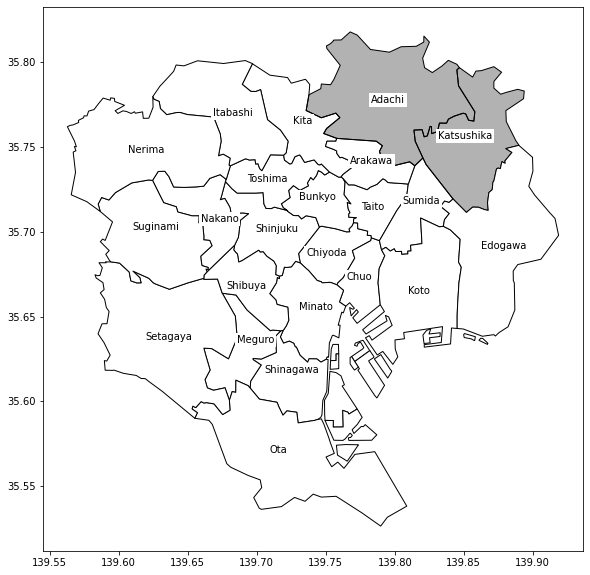

In [31]:
Tokyo_gdf['is_hotspot'] = Tokyo_gdf['SIKUCHOSON'].isin(hotspots.iloc[0]['spot'])
plot_labeled_map(Tokyo_gdf, 'name', 'is_hotspot')